In [7]:
RUN_FROM_SCRATCH = True  # set False to load saved results
SEED = 7

import os, json, numpy as np, torch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

torch.manual_seed(SEED); np.random.seed(SEED)
MODEL_DIR = "../model_gan"


In [5]:
import sys; sys.path.append(MODEL_DIR)
from preprocess import load_and_preprocess
from model import Generator, Discriminator, QNetwork

X = load_and_preprocess()
N, D = X.shape
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if RUN_FROM_SCRATCH:
    # minimal training loop (same hyperparams as train.py)
    import torch.nn as nn, torch.optim as optim
    NOISE_DIM, CODE_DIM, HIDDEN_DIM = 10, 5, 64
    LR, EPOCHS, BATCH = 2e-4, 400, 64

    X_tensor = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    ds = torch.utils.data.TensorDataset(X_tensor)
    dl = torch.utils.data.DataLoader(ds, batch_size=BATCH, shuffle=True, drop_last=True)

    G = Generator(NOISE_DIM, CODE_DIM, D, HIDDEN_DIM).to(DEVICE)
    Dnet = Discriminator(D, HIDDEN_DIM).to(DEVICE)
    Q = QNetwork(HIDDEN_DIM, CODE_DIM).to(DEVICE)
    bce_logits = nn.BCEWithLogitsLoss(); xent = nn.CrossEntropyLoss()
    optD = optim.Adam(Dnet.parameters(), lr=LR)
    optGQ = optim.Adam(list(G.parameters()) + list(Q.parameters()), lr=LR)

    for ep in range(1, EPOCHS+1):
        for (xb,) in dl:
            bs = xb.size(0)
            # D
            Dnet.zero_grad()
            h_real, d_real = Dnet(xb, return_features=True)
            loss_real = bce_logits(d_real, torch.ones(bs,1,device=DEVICE))
            z = torch.randn(bs, NOISE_DIM, device=DEVICE)
            c_idx = torch.randint(0, CODE_DIM, (bs,), device=DEVICE)
            c1 = torch.zeros(bs, CODE_DIM, device=DEVICE); c1[torch.arange(bs), c_idx]=1.
            x_fake = G(z, c1)
            _, d_fake = Dnet(x_fake.detach(), return_features=True)
            loss_fake = bce_logits(d_fake, torch.zeros(bs,1,device=DEVICE))
            (loss_real+loss_fake).backward(); optD.step()
            # G+Q
            G.zero_grad(); Q.zero_grad()
            h_fake, d_fake2 = Dnet(x_fake, return_features=True)
            g_loss = bce_logits(d_fake2, torch.ones(bs,1,device=DEVICE))
            q_logits = Q(h_fake); q_loss = xent(q_logits, c_idx)
            (g_loss+q_loss).backward(); optGQ.step()
        if ep%100==0 or ep in (1,EPOCHS): print(ep)
    # predict labels
    with torch.no_grad():
        h, _ = Dnet(X_tensor, return_features=True)
        probs = torch.softmax(Q(h), dim=1).cpu().numpy()
    labels = probs.argmax(axis=1)
    np.save(os.path.join(MODEL_DIR,"clusters.npy"), labels)
    sil = float(silhouette_score(X, labels)); db = float(davies_bouldin_score(X, labels))
    with open(os.path.join(MODEL_DIR,"results.json"),"w") as f:
        json.dump({"model":"GAN","silhouette":sil,"dbi":db}, f, indent=2)
else:
    labels = np.load(os.path.join(MODEL_DIR,"clusters.npy"))
    with open(os.path.join(MODEL_DIR,"results.json")) as f:
        r = json.load(f); sil, db = r["silhouette"], r["dbi"]


1
100
200
300
400


Silhouette=0.7008, DBI=1.0283


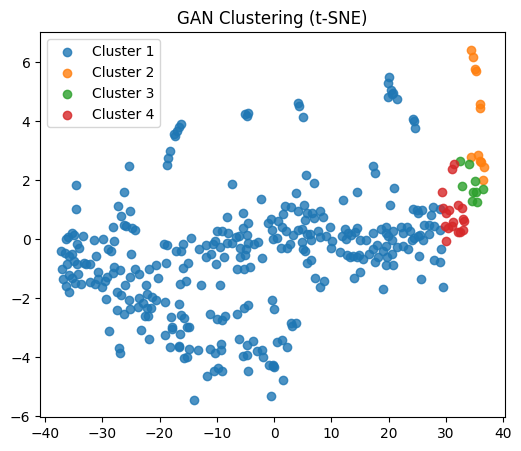

In [6]:
if RUN_FROM_SCRATCH:
    print(f"Silhouette={sil:.4f}, DBI={db:.4f}")
else:
    print(f"Loaded results: Silhouette={sil:.4f}, DBI={db:.4f}")

X2 = TSNE(n_components=2, init='pca', random_state=SEED).fit_transform(X)
plt.figure(figsize=(6,5))
for k in np.unique(labels):
    plt.scatter(X2[labels==k,0], X2[labels==k,1], label=f"Cluster {k}", alpha=0.8)
plt.title("GAN Clustering (t-SNE)"); plt.legend(); plt.show()
